In [1]:
from __future__ import print_function 
from keras.layers import Input, Dense, Dropout, Activation, Concatenate, BatchNormalization
from keras.models import Model
from keras.layers import Conv2D, GlobalAveragePooling2D, AveragePooling2D
from keras.regularizers import l2


2023-10-27 18:44:31.575156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 18:44:31.575204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 18:44:31.575246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 18:44:31.583808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 18:44:32.376093: W tensorflow/compiler/

In [2]:
def DenseNet(input_shape=None, dense_blocks=5, dense_layers=-1, growth_rate=12, nb_classes=None, dropout_rate=None,
             bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):
    """
    Creating a DenseNet
    
    Arguments:
        input_shape  : shape of the input images. E.g. (28,28,1) for MNIST    
        dense_blocks : amount of dense blocks that will be created (default: 3)    
        dense_layers : number of layers in each dense block. You can also use a list for numbers of layers [2,4,3]
                       or define only 2 to add 2 layers at all dense blocks. -1 means that dense_layers will be calculated
                       by the given depth (default: -1)
        growth_rate  : number of filters to add per dense block (default: 12)
        nb_classes   : number of classes
        dropout_rate : defines the dropout rate that is accomplished after each conv layer (except the first one).
                       In the paper the authors recommend a dropout of 0.2 (default: None)
        bottleneck   : (True / False) if true it will be added in convolution block (default: False)
        compression  : reduce the number of feature-maps at transition layer. In the paper the authors recomment a compression
                       of 0.5 (default: 1.0 - will have no compression effect)
        weight_decay : weight decay of L2 regularization on weights (default: 1e-4)
        depth        : number or layers (default: 40)
        
    Returns:
        Model        : A Keras model instance
    """
    
    if nb_classes==None:
        raise Exception('Please define number of classes (e.g. num_classes=10). This is required for final softmax.')
    
    if compression <=0.0 or compression > 1.0:
        raise Exception('Compression have to be a value between 0.0 and 1.0. If you set compression to 1.0 it will be turn off.')
    
    if type(dense_layers) is list:
        if len(dense_layers) != dense_blocks:
            raise AssertionError('Number of dense blocks have to be same length to specified layers')
    elif dense_layers == -1:
        if bottleneck:
            dense_layers = (depth - (dense_blocks + 1))/dense_blocks // 2
        else:
            dense_layers = (depth - (dense_blocks + 1))//dense_blocks
        dense_layers = [int(dense_layers) for _ in range(dense_blocks)]
    else:
        dense_layers = [int(dense_layers) for _ in range(dense_blocks)]
        
    img_input = Input(shape=input_shape)
    nb_channels = growth_rate * 2
    
    print('Creating DenseNet')
    print('#############################################')
    print('Dense blocks: %s' % dense_blocks)
    print('Layers per dense block: %s' % dense_layers)
    print('#############################################')
    
    # Initial convolution layer
    x = Conv2D(nb_channels, (3,3), padding='same',strides=(1,1),
                      use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)
    
    # Building dense blocks
    for block in range(dense_blocks):
        
        # Add dense block
        x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate, dropout_rate, bottleneck, weight_decay)
        
        if block < dense_blocks - 1:  # if it's not the last dense block
            # Add transition_block
            x = transition_layer(x, nb_channels, dropout_rate, compression, weight_decay)
            nb_channels = int(nb_channels * compression)
    
    x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(nb_classes, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay))(x)
    
    model_name = None
    if growth_rate >= 36:
        model_name = 'widedense'
    else:
        model_name = 'dense'
        
    if bottleneck:
        model_name = model_name + 'b'
        
    if compression < 1.0:
        model_name = model_name + 'c'
        
    return Model(img_input, x, name=model_name), model_name

In [3]:
def dense_block(x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a dense block and concatenates inputs
    """
    
    x_list = [x]
    for i in range(nb_layers):
        cb = convolution_block(x, growth_rate, dropout_rate, bottleneck, weight_decay)
        x_list.append(cb)
        x = Concatenate(axis=-1)(x_list)
        nb_channels += growth_rate
    return x, nb_channels

In [4]:
def convolution_block(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a convolution block consisting of BN-ReLU-Conv.
    Optional: bottleneck, dropout
    """
    
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels * bottleneckWidth, (1, 1), use_bias=False, kernel_regularizer=l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
    
    # Standard (BN-ReLU-Conv)
    x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_channels, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(weight_decay))(x)
    
    # Dropout
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    return x


In [5]:
def transition_layer(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
    """
    Creates a transition layer between dense blocks as transition, which do convolution and pooling.
    Works as downsampling.
    """
    
    x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_channels*compression), (1, 1), padding='same',
                      use_bias=False, kernel_regularizer=l2(weight_decay))(x)
    
    # Adding dropout
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

In [18]:
model, model_name = DenseNet(input_shape = (28,28,1), nb_classes=5, dropout_rate = 0.2)

Creating DenseNet
#############################################
Dense blocks: 5
Layers per dense block: [6, 6, 6, 6, 6]
#############################################


In [19]:
model.summary()

Model: "dense"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 28, 28, 24)           216       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_35 (Ba  (None, 28, 28, 24)           96        ['conv2d_35[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_35 (Activation)  (None, 28, 28, 24)           0         ['batch_normalization_35[0

In [20]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file = 'densenet_arch.png')

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [23]:
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range = 10)
train_images = train_datagen.flow_from_directory('/home/mrroy/Dataset/CLASS/train/', color_mode='grayscale', target_size=(28, 28), batch_size=32)
val_datagen = ImageDataGenerator(rescale=1.0/255)
validation_images = val_datagen.flow_from_directory('/home/mrroy/Dataset/CLASS/validation/', color_mode='grayscale', target_size=(28, 28), batch_size=32)


Found 24573 images belonging to 5 classes.
Found 3516 images belonging to 5 classes.


In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
STEP_SIZE_TRAIN = train_images.n//train_images.batch_size
STEP_SIZE_VALID = validation_images.n//validation_images.batch_size
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath='densenet_models/densenet_model1.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, mode='max', verbose=1)

# Create a list of callbacks, including ModelCheckpoint and EarlyStopping
callbacks_list = [checkpoint, early_stopping]

# Start training
history = model.fit_generator(generator=train_images,
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=validation_images,
                               validation_steps=STEP_SIZE_VALID,
                               callbacks=callbacks_list,
                               epochs=100)


/tmp/ipykernel_8191/2035650012.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_images,


Epoch 1/100


2023-10-27 18:52:26.068930: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indense/dropout_34/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


767/767 [==============================] - ETA: 0s - loss: 1.4313 - accuracy: 0.7309
Epoch 1: val_accuracy improved from -inf to 0.73308, saving model to densenet_models/densenet_model1.h5


/home/mrroy/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 186s 227ms/step - loss: 1.4313 - accuracy: 0.7309 - val_loss: 1.1899 - val_accuracy: 0.7331
Epoch 2/100
767/767 [==============================] - ETA: 0s - loss: 1.0974 - accuracy: 0.7326
Epoch 2: val_accuracy did not improve from 0.73308
767/767 [==============================] - 169s 220ms/step - loss: 1.0974 - accuracy: 0.7326 - val_loss: 1.0845 - val_accuracy: 0.7004
Epoch 3/100
767/767 [==============================] - ETA: 0s - loss: 0.9948 - accuracy: 0.7346
Epoch 3: val_accuracy improved from 0.73308 to 0.73337, saving model to densenet_models/densenet_model1.h5
767/767 [==============================] - 176s 230ms/step - loss: 0.9948 - accuracy: 0.7346 - val_loss: 0.9584 - val_accuracy: 0.7334
Epoch 4/100
767/767 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.7325
Epoch 4: val_accuracy did not improve from 0.73337
767/767 [==============================] - 172s 224ms/step - loss: 0.9543 - accuracy: 0.7325 - 

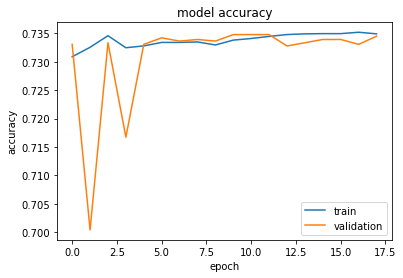

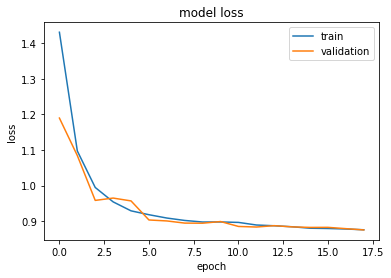

In [26]:
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    
    plt.show()

In [27]:
from keras.models import load_model
m = load_model('densenet_models/densenet_model1.h5')

In [28]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_images = test_datagen.flow_from_directory('/home/mrroy/Dataset/CLASS/test/',  color_mode = 'grayscale', target_size = (28, 28), batch_size = 32)
p = m.evaluate_generator(test_images, verbose=1, steps=test_images.n//test_images.batch_size)
print(p)

Found 7019 images belonging to 5 classes.


/tmp/ipykernel_8191/2302545426.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  p = m.evaluate_generator(test_images, verbose=1, steps=test_images.n//test_images.batch_size)


219/219 [==============================] - 50s 222ms/step - loss: 0.8975 - accuracy: 0.7353
[0.8975127339363098, 0.7353025078773499]


In [29]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_images = test_datagen.flow_from_directory('/home/mrroy/Dataset/CLASS/test/',  color_mode = 'grayscale', target_size = (28, 28), batch_size = 32, shuffle = False)

Found 7019 images belonging to 5 classes.


In [30]:
y_pred = m.predict_generator(generator = test_images, verbose = 1)
y_pred = y_pred.argmax(axis=-1)

/tmp/ipykernel_8191/404438757.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = m.predict_generator(generator = test_images, verbose = 1)


220/220 [==============================] - 50s 227ms/step


In [31]:
from sklearn.metrics import classification_report, precision_score, confusion_matrix, accuracy_score, f1_score, recall_score

In [32]:
print(classification_report(test_images.classes[test_images.index_array], y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      5160
           1       0.00      0.00      0.00       487
           2       0.00      0.00      0.00      1057
           3       0.00      0.00      0.00       174
           4       0.00      0.00      0.00       141

    accuracy                           0.74      7019
   macro avg       0.15      0.20      0.17      7019
weighted avg       0.54      0.74      0.62      7019



/home/mrroy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mrroy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mrroy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
print('precision')
p1 = precision_score(test_images.classes[test_images.index_array], y_pred, average = 'weighted')
print(p1*100)
print('recall')
r1 = recall_score(test_images.classes[test_images.index_array], y_pred, average = 'weighted')
print(r1*100)
print('f1')
f11 = f1_score(test_images.classes[test_images.index_array], y_pred, average = 'weighted')
print(f11*100)
print('accuracy')
a1 = accuracy_score(test_images.classes[test_images.index_array], y_pred)
print(a1*100)

precision
54.044178339049644
recall
73.51474569026927
f1
62.29347036075039
accuracy
73.51474569026927


/home/mrroy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from keras.models import load_model
m = load_model('densenet_models/densenet_model1.h5')